# Trying Feature Map Extraction

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load a pre-trained CNN (VGG16)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model


In [ ]:
# Load VGG16 without the fully connected (FC) layers
model = VGG16(weights="imagenet", include_top=False)

# Print layer names to find convolutional layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output.shape)


0 input_layer_1 (None, None, None, 3)
1 block1_conv1 (None, None, None, 64)
2 block1_conv2 (None, None, None, 64)
3 block1_pool (None, None, None, 64)
4 block2_conv1 (None, None, None, 128)
5 block2_conv2 (None, None, None, 128)
6 block2_pool (None, None, None, 128)
7 block3_conv1 (None, None, None, 256)
8 block3_conv2 (None, None, None, 256)
9 block3_conv3 (None, None, None, 256)
10 block3_pool (None, None, None, 256)
11 block4_conv1 (None, None, None, 512)
12 block4_conv2 (None, None, None, 512)
13 block4_conv3 (None, None, None, 512)
14 block4_pool (None, None, None, 512)
15 block5_conv1 (None, None, None, 512)
16 block5_conv2 (None, None, None, 512)
17 block5_conv3 (None, None, None, 512)
18 block5_pool (None, None, None, 512)


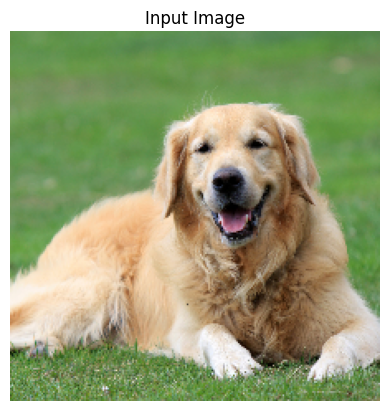

In [ ]:
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match VGG16 input size
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize (optional, some models require preprocessing)
    return img

# Load an example image
img_path = "dog.jpg"  # Change this to any image you have
input_image = load_and_preprocess_image(img_path)

# Show the input image
plt.imshow(input_image[0])
plt.axis("off")
plt.title("Input Image")
plt.show()


In [ ]:
# Select a convolutional layer (e.g., first conv layer)
layer_name = "block1_conv1"  # Change to any conv layer from the model
layer_output = model.get_layer(layer_name).output

# Create a new model that outputs the feature maps
feature_map_model = Model(inputs=model.input, outputs=layer_output)

# Get feature maps
feature_maps = feature_map_model.predict(input_image)
print("Feature Map Shape:", feature_maps.shape)  # Example: (1, 224, 224, 64)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Feature Map Shape: (1, 224, 224, 64)


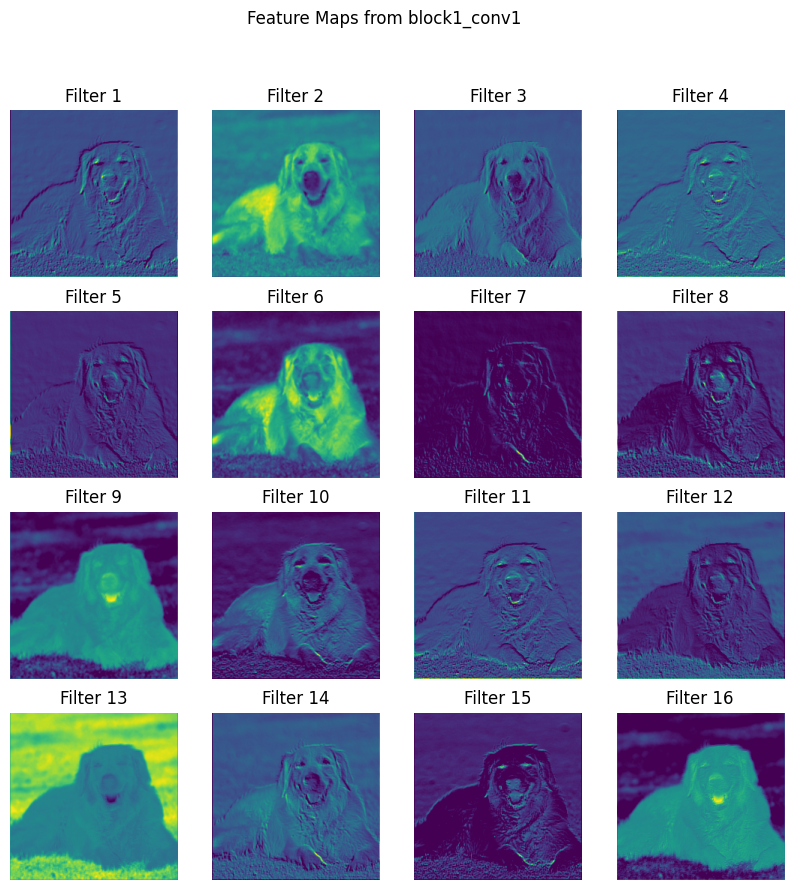

In [ ]:
# Number of feature maps (filters)
num_filters = feature_maps.shape[-1]

# Plot some feature maps
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i in range(16):  # Display first 16 feature maps
    ax = axes[i // 4, i % 4]
    ax.imshow(feature_maps[0, :, :, i], cmap="viridis")  # Display feature map
    ax.axis("off")
    ax.set_title(f"Filter {i+1}")

plt.suptitle(f"Feature Maps from {layer_name}")
plt.show()


# Trying Student Model Training using Feature Maps - VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import numpy as np

# Load a pretrained Teacher Model (VGG16)
teacher_model = VGG16(weights="imagenet", include_top=False)

# Select an intermediate convolutional layer
layer_name = "block3_conv3"  # Choose a deep layer for meaningful features
teacher_layer = teacher_model.get_layer(layer_name).output

# Define a new model that outputs feature maps
teacher_feature_model = Model(inputs=teacher_model.input, outputs=teacher_layer)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Define a small Student Model
def build_student_model():
    inputs = Input(shape=(224, 224, 3))

    x = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2,2))(x)  # Reduces size to 112x112

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)  # Reduces size to 56x56 (matches teacher)

    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)  # Keep same channels
    x = MaxPooling2D(pool_size=(2,2))(x)  # Reduces size to 28x28

    model = Model(inputs, x, name="StudentModel")
    return model

student_model = build_student_model()



In [ ]:
import tensorflow.keras.backend as K

# Feature Map Distillation Loss
def feature_distillation_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))  # MSE loss between feature maps


In [ ]:
import tensorflow as tf

def resize_teacher_features(teacher_features, target_shape=(28, 28)):
    return tf.image.resize(teacher_features, target_shape, method=tf.image.ResizeMethod.BILINEAR)

In [ ]:
# Compile Student Model
student_model.compile(optimizer="adam", loss=feature_distillation_loss)

# Generate example data
import cv2
import matplotlib.pyplot as plt

# Load and preprocess a sample image
img_path = "dog.jpg"  # Make sure the image exists
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0) / 255.0  # Normalize

# Get feature maps from the Teacher
teacher_features = teacher_feature_model.predict(img)

teacher_features_resized = resize_teacher_features(teacher_features)

# Train the Student Model on this feature map
student_model.fit(img, teacher_features_resized, epochs=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 57.1900
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step - loss: 56.8011
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - loss: 56.1366
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step - loss: 55.1020
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 53.6411
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step - loss: 51.7703
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - loss: 49.5876
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step - loss: 47.2823
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 45.1265
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 43.3852


**💡 Best Practice: Distill mid-layer and final-layer features for better knowledge transfer.**

# Trying Student Model Training using Feature Maps - ResNET

## 1. Understanding Feature Map Differences (ResNet-50 vs. ResNet-18)

Since ResNet-50 is deeper than ResNet-18, their **feature maps** have different spatial sizes (`H × W`) and channel dimensions (`C`).

| **Block** | **Teacher - ResNet-50 Feature Map Shape** | **Student - ResNet-18 Feature Map Shape** |
|-----------|---------------------------------|---------------------------------|
| **Conv1** | `(112,112,64)` | `(112,112,64)` ✅ |
| **Stage 1 (Res2)** | `(56,56,256)` | `(56,56,64)` ❌ |
| **Stage 2 (Res3)** | `(28,28,512)` | `(28,28,128)` ❌ |
| **Stage 3 (Res4)** | `(14,14,1024)` | `(14,14,256)` ❌ |
| **Stage 4 (Res5)** | `(7,7,2048)` | `(7,7,512)` ❌ |
| **Final Features** | `(1,1,2048)` | `(1,1,512)` ❌ |

🔹 **Problem:** Feature maps from ResNet-50 **don’t match** with ResNet-18 in channel count (`C`).  
🔹 **Solution:** We need to **align feature maps** using **1×1 Conv layers** and **resizing**.

---


## Use Both Channel & Spatial Matching (Best Practice)

Resize teacher feature maps (`H × W`)

Apply a `1×1 Conv` to match channels (`C`)

```python
class FeatureAligner(torch.nn.Module):
    def __init__(self, teacher_channels, student_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(teacher_channels, student_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
```
---

## Where to Apply Knowledge Distillation?

We should **only distill selected layers**, not all, to reduce computation and improve efficiency.

### 🔹 Key Observations:
- **ResNet-50 has deeper layers with higher channel dimensions** than ResNet-18.
- **Feature maps at different stages have mismatched spatial and channel dimensions**.
- **Distillation should be applied at meaningful intermediate layers** where feature representations are informative.

### ✅ **Comparison of Feature Maps Between Teacher (ResNet-50) and Student (ResNet-18)**

| **Teacher (ResNet-50 Feature Map)** | **Student (ResNet-18 Feature Map)** | **Alignment Needed?** |
|------------------|------------------|------------------|
| **Conv1 (112×112×64)** | **Conv1 (112×112×64)** | ❌ No change needed |
| **Res2 (56×56×256)** | **Res2 (56×56×64)** | ✅ 1×1 Conv to 64 channels |
| **Res3 (28×28×512)** | **Res3 (28×28×128)** | ✅ 1×1 Conv to 128 channels |
| **Res4 (14×14×1024)** | **Res4 (14×14×256)** | ✅ 1×1 Conv to 256 channels |
| **Res5 (7×7×2048)** | **Res5 (7×7×512)** | ✅ 1×1 Conv to 512 channels |

### 🎯 **Best Layers for Feature Distillation**
The following layers **capture rich, high-level representations**, making them the best candidates for knowledge distillation:

✅ **Res3 (28×28)**  
✅ **Res4 (14×14)**  
✅ **Res5 (7×7)**  

By aligning feature maps at these layers, we can **effectively transfer important high-level knowledge** from the teacher model (ResNet-50) to the student model (ResNet-18) while keeping computational costs manageable.

---

## Loss Function for Feature Distillation

To transfer knowledge, minimize the Mean Squared Error (MSE) loss between aligned teacher and student features.

```python
import torch.nn.functional as F

# Compute loss (MSE loss for distillation)
loss = F.mse_loss(aligned_teacher_feature, student_features['layer3'])
print("Feature Distillation Loss:", loss.item())
```

✅ Apply at selected layers (e.g., Res3, Res4, Res5).   
✅ Combine with standard cross-entropy loss for classification.

---

In [ ]:
import torch
import torchvision.models as models

# Load pre-trained models
resnet50 = models.resnet50(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

# Set models to evaluation mode (important for distillation)
print("ResNet 50:")
print(resnet50.eval())

print("----------------------------------------------------------------------")

print("ResNet 18:")
print(resnet18.eval())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weig

ResNet 50:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [ ]:
from collections import OrderedDict

# Function to get feature maps from intermediate layers
class FeatureExtractor(torch.nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers  # List of layer names to extract
        self.outputs = OrderedDict()

        # Register hooks to capture feature maps
        for name, layer in self.model.named_children():
            if name in layers:
                layer.register_forward_hook(self.hook_fn(name))

    def hook_fn(self, name):
        def hook(module, input, output):
            self.outputs[name] = output
        return hook

    def forward(self, x):
        _ = self.model(x)  # Forward pass
        return self.outputs


In [ ]:
# Define the layers to extract (ResNet-50 and ResNet-18 have different depths)
selected_layers = ['layer1', 'layer2', 'layer3', 'layer4']

# Create feature extractors
teacher_extractor = FeatureExtractor(resnet50, selected_layers)
student_extractor = FeatureExtractor(resnet18, selected_layers)

# Test with a dummy input
dummy_input = torch.randn(1, 3, 224, 224)

# Get feature maps
teacher_features = teacher_extractor(dummy_input)
student_features = student_extractor(dummy_input)

# Print extracted features
for layer in selected_layers:
    print(f"{layer}: Teacher -> {teacher_features[layer].shape}, Student -> {student_features[layer].shape}")


layer1: Teacher -> torch.Size([1, 256, 56, 56]), Student -> torch.Size([1, 64, 56, 56])
layer2: Teacher -> torch.Size([1, 512, 28, 28]), Student -> torch.Size([1, 128, 28, 28])
layer3: Teacher -> torch.Size([1, 1024, 14, 14]), Student -> torch.Size([1, 256, 14, 14])
layer4: Teacher -> torch.Size([1, 2048, 7, 7]), Student -> torch.Size([1, 512, 7, 7])


In [ ]:
import torch.nn.functional as F

# Define a 1x1 conv layer to align dimensions
class FeatureAligner(torch.nn.Module):
    def __init__(self, teacher_channels, student_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(teacher_channels, student_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Example for layer3 (ResNet-50 has 1024 channels, ResNet-18 has 256)
aligner = FeatureAligner(teacher_channels=1024, student_channels=256)

# Example forward pass
aligned_teacher_feature = aligner(teacher_features['layer3'])

# Compute loss (MSE loss for distillation)
loss = F.mse_loss(aligned_teacher_feature, student_features['layer3'])
print("Feature Distillation Loss:", loss.item())


Feature Distillation Loss: 0.0358797125518322


# Actual Code - Steps for Training Student Model with a Pretrained Teacher

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import zipfile

# Extract dataset
with zipfile.ZipFile("/content/drive/MyDrive/ScalableComputingProject/celeba/img_align_celeba.zip", "r") as zip_ref:
    zip_ref.extractall("/content/celeba/")

In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np

# class CelebADataset(Dataset):
#     def __init__(self, root_dir, attr_file, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.data = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
#         self.data = self.data.reset_index()  # Reset index to get filenames

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])  # Image filename
#         image = Image.open(img_name).convert("RGB")

#         # Get attributes (Example: Gender - 1 for Male, 0 for Female)
#         label = (self.data.iloc[idx, 1:].values + 1) // 2  # Convert (-1,1) to (0,1)

#         # Ensure label is a valid numeric array (convert to float32)
#         label = np.array(label, dtype=np.float32)

#         label = torch.tensor(label)

#         if self.transform:
#             image = self.transform(image)

#         return image, label


class CelebADataset(Dataset):
    def __init__(self, root_dir, csv_path, partition_csv_path, split, transform=None):
        # Load attributes
        self.df = pd.read_csv(csv_path).replace(-1, 0)

        # Load partition data with header
        partition_df = pd.read_csv(partition_csv_path)
        partition_df['partition'] = partition_df['partition'].astype(int)

        # Merge datasets
        self.df = self.df.merge(partition_df, on='image_id', how='inner')

        # Convert split name to code
        split_codes = {'train': 0, 'valid': 1, 'validation': 1, 'test': 2}
        split = split.lower()
        if split not in split_codes:
            raise ValueError(f"Invalid split: {split}. Use train/valid/test")

        split_code = split_codes[split]
        self.df = self.df[self.df['partition'] == split_code].copy()

        # Validate dataset
        if len(self.df) == 0:
            raise ValueError(f"No samples found for {split} partition")

        self.root_dir = root_dir
        self.transform = transform
        self.labels = self.df.drop(['image_id', 'partition'], axis=1).values.astype('float32')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]['image_id'])
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            image = torch.zeros(3, 224, 224)
        return image, self.labels[idx]


# Define paths
image_dir = "/content/celeba/img_align_celeba/"
attr_file = "/content/drive/MyDrive/ScalableComputingProject/celeba/list_attr_celeba.csv"
partition_file = "/content/drive/MyDrive/ScalableComputingProject/celeba/list_eval_partition.csv"
teacher_model_path = "/content/drive/MyDrive/ScalableComputingProject/Teacher/Teacher.pth"

In [4]:
import os

num_images = len(os.listdir(image_dir))
print(f"Number of images found: {num_images}")

Number of images found: 202599


In [5]:
# Optimizer
# https://github.com/szagoruyko/attention-transfer/blob/master/imagenet.py#L225

from torch.optim import SGD

def create_optimizer(optimizable, lr, weight_decay):
    print("creating optimizer with lr = ", lr, "and weight decay = ", weight_decay)
    return SGD(optimizable, lr, momentum=0.9, weight_decay=weight_decay)


**Why This Works?**
- KD Loss → Transfers soft label knowledge from teacher to student.
- CE Loss → Ensures classification performance.
- Cosine Similarity Loss → Aligns feature representations for better generalization.

In [6]:
# Loss Function for Classification
# https://github.com/szagoruyko/attention-transfer/blob/master/utils.py#L10

import torch.nn.functional as F

def distillation_loss(student_logits, teacher_logits, student_features, teacher_features, labels, temperature, alpha, beta):
    """
    Computes the combined Knowledge Distillation + Cosine Similarity loss.

    Parameters:
    - student_logits: Logits from the student model
    - teacher_logits: Logits from the teacher model
    - student_features: Feature maps from the student model
    - teacher_features: Feature maps from the teacher model
    - labels: Ground truth labels
    - temperature: Temperature scaling factor for distillation
    - alpha: Weighting factor for KD loss vs. Cross-Entropy loss
    - beta: Weighting factor for Cosine Similarity loss

    Returns:
    - Combined loss
    """

    # Knowledge Distillation (KD) Loss
    teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
    student_log_probs = F.log_softmax(student_logits / temperature, dim=1)
    kd_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (temperature ** 2)

    # Binary Cross-Entropy (CE) Loss
    ce_loss = F.binary_cross_entropy_with_logits(student_logits, labels.float(), reduction='mean')

    # Cosine Similarity Loss
    cosine_similarities = {}

    for layer in teacher_features.keys():
        teacher_fmap = teacher_features[layer]  # Get teacher's feature map
        student_fmap = student_features[layer]  # Get student's feature map

        # Adaptive Pooling to ensure fixed spatial size before flattening
        adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))

        if len(teacher_fmap.shape) == 4:
            teacher_fmap = adaptive_pool(teacher_fmap)
            student_fmap = adaptive_pool(student_fmap)

        # Flatten the feature maps
        teacher_fmap = teacher_fmap.view(teacher_fmap.shape[0], -1)
        student_fmap = student_fmap.view(student_fmap.shape[0], -1)

        # Ensure both tensors have the same feature size
        min_features = min(teacher_fmap.shape[1], student_fmap.shape[1])
        teacher_fmap = teacher_fmap[:, :min_features]
        student_fmap = student_fmap[:, :min_features]

        # Compute cosine similarity
        similarity = F.cosine_similarity(teacher_fmap, student_fmap, dim=1).mean()  # Mean over batch
        cosine_similarities[layer] = similarity.item()

    cosine_loss = sum(1 - similarity for similarity in cosine_similarities.values()) / len(cosine_similarities)

    # Final Loss (Weighted Combination)
    total_loss = (alpha * kd_loss) + ((1 - alpha) * ce_loss) + (beta * cosine_loss)

    return total_loss


In [7]:
# Train the Student Model with Knowledge Distillation
# https://github.com/szagoruyko/attention-transfer/blob/master/imagenet.py#L69

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as T


def get_iterator(image_dir, attr_file, partition_file, batch_size=32, mode=True):

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

    eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    image_dir = os.path.expanduser(image_dir)
    attr_file = os.path.expanduser(attr_file)



    print("| setting up data loader...")
    if mode:

        try:
            train_set = CelebADataset(
                root_dir = image_dir,
                csv_path = attr_file,
                partition_csv_path = partition_file,
                split = 'train',
                transform = train_transform
            )

            data_loader = DataLoader(
                train_set,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=True
            )
        except Exception as e:
            print(f"Error creating dataset: {str(e)}")
            raise
    else:

        try:
            val_set = CelebADataset(
                image_dir,
                attr_file,
                partition_file,
                split='valid',
                transform=eval_transform
            )

            data_loader = DataLoader(
                val_set,
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )
        except Exception as e:
            print(f"Error creating dataset: {str(e)}")
            raise

    return data_loader


# def get_iterator(image_dir, attr_file, batch_size=32, shuffle=True):
#     image_dir = os.path.expanduser(image_dir)
#     attr_file = os.path.expanduser(attr_file)

#     normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#     print("| setting up data loader...")

#     ds = CelebADataset(image_dir, attr_file, transform=T.Compose([
#         T.RandomResizedCrop(224),
#         T.RandomHorizontalFlip(),
#         T.ToTensor(),
#         normalize,
#     ]))

#     return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = get_iterator(image_dir, attr_file, partition_file, batch_size=32, mode=True)
val_loader = get_iterator(image_dir, attr_file, partition_file, batch_size=32, mode=False)

# Test loading one sample
image, label = next(iter(train_loader))
print("Image shape:", image.shape)
print("Label shape:", label.shape)

| setting up data loader...
| setting up data loader...
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32, 40])


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Feature aligners to match teacher-student dimensions
class FeatureAligner(nn.Module):
    def __init__(self, teacher_channels, student_channels):
        super().__init__()
        self.conv = nn.Conv2d(teacher_channels, student_channels, kernel_size=1)  # 1x1 conv to align channels

    def forward(self, x):
        return self.conv(x)

# Define aligners for each layer
aligners = {
    "layer1": FeatureAligner(teacher_channels=256, student_channels=64),
    "layer2": FeatureAligner(teacher_channels=512, student_channels=128),
    "layer3": FeatureAligner(teacher_channels=1024, student_channels=256),
    "layer4": FeatureAligner(teacher_channels=2048, student_channels=512)
}

In [9]:
# Load the Teacher (ResNet-50) and Student (ResNet-18) Models

import torch
import torchvision.models as models

# Define Hyperparameters
temperature = 4.0   # Higher values soften the distribution
alpha = 0.7         # Weighting between distillation loss and CE loss
num_epochs = 10

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 40  # For CelebA

# Load the trained teacher model (ResNet-50)
teacher_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# teacher_model.fc = torch.nn.Linear(2048, num_classes)  # Adjust the output layer
teacher_model.fc = torch.nn.Sequential(
            torch.nn.Linear(teacher_model.fc.in_features, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, num_classes)
        )
teacher_model.load_state_dict(torch.load(teacher_model_path, map_location=torch.device('cpu')), strict=False)  # Load your trained weights
teacher_model.eval()  # Set to evaluation mode

# Initialize the student model (ResNet-18)
student_model = models.resnet18(pretrained=True)
student_model.fc = torch.nn.Linear(512, num_classes)  # Adjust output layer

student_model.to(device)
teacher_model.to(device)

for aligner in aligners.values():
    aligner.to(device)

optimizer = create_optimizer(optimizable=student_model.parameters(), lr=0.01, weight_decay=5e-4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


creating optimizer with lr =  0.01 and weight decay =  0.0005


In [10]:
# Extract Feature Maps from Both Models

from collections import OrderedDict

# Feature extractor class
class FeatureExtractor(torch.nn.Module):
    def __init__(self, model, layers):
        super().__init__()
        self.model = model
        self.layers = layers  # List of layer names to extract
        self.outputs = OrderedDict()

        # Register hooks
        for name, layer in self.model.named_children():
            if name in layers:
                layer.register_forward_hook(self.hook_fn(name))

    def hook_fn(self, name):
        def hook(module, input, output):
            self.outputs[name] = output
        return hook

    def forward(self, x):
        _ = self.model(x)  # Forward pass
        return self.outputs

# Select layers from both models
# selected_layers = ['layer1', 'layer2', 'layer3', 'layer4']
selected_layers = ['layer2', 'layer3']


# Create feature extractors
teacher_extractor = FeatureExtractor(teacher_model, selected_layers)
student_extractor = FeatureExtractor(student_model, selected_layers)


In [11]:
import torch
import os

# Define checkpoint directory in Google Drive (or local)
checkpoint_path = "/content/drive/MyDrive/ScalableComputingProject/StudentAT/checkpoints/student_at_checkpoint.pth"

def save_checkpoint(epoch, model, optimizer, loss):
    """
    Save model checkpoint to avoid loss of progress.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at Epoch {epoch}")

def load_checkpoint(model, optimizer):
    """
    Load the latest checkpoint if it exists.
    """
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Resume from next epoch
        print(f"Resuming training from Epoch {start_epoch}")
        return start_epoch
    else:
        print("Starting training from scratch")
        return 0  # Start from the beginning

In [12]:
import time

# Load checkpoint if available
start_epoch = load_checkpoint(student_model, optimizer)

cosine_similarities = {}

# Training Loop with Checkpointing
for epoch in range(start_epoch, num_epochs):

    # Training Phase
    student_model.train()  # Set student model to training mode

    for batch_idx, (images, labels) in enumerate(train_loader):  # Iterate through data
        images, labels = images.to(device), labels.to(device)

        # Forward pass (Teacher model)
        with torch.no_grad():  # No gradients needed for teacher
            teacher_logits = teacher_model(images)
            teacher_features = teacher_extractor(images)

        # Forward pass (Student model)
        student_logits = student_model(images)
        student_features = student_extractor(images)

        # Compute loss
        loss = distillation_loss(student_logits, teacher_logits, student_features, teacher_features, labels, temperature=4.0, alpha=0.7, beta=0.1)  # Adjust `alpha` and `beta` as needed

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch {batch_idx + 1},  training_loss: {loss.item():.4f}")

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save checkpoint after each epoch
    save_checkpoint(epoch, student_model, optimizer, loss.item())

    # Validation Phase
    val_losses = []
    val_start = time.time()
    student_model.eval()

    for batch_idx, (images, labels) in enumerate(val_loader):  # Iterate through data
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():  # No gradients needed
            # Forward pass (Teacher model)
            teacher_logits = teacher_model(images)
            teacher_features = teacher_extractor(images)

            # Forward pass (Student model)
            student_logits = student_model(images)
            student_features = student_extractor(images)

        # Compute loss
        val_loss = distillation_loss(student_logits, teacher_logits, student_features, teacher_features, labels, temperature=4.0, alpha=0.7, beta=0.1)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch {batch_idx + 1},  val_loss: {val_loss.item():.4f}")

    val_time = time.time() - val_start
    val_loss = sum(val_losses) / len(val_losses)

    print(f"Epoch [{epoch+1}/{num_epochs}], val_loss: {val_loss.item():.4f}, val_time: {val_time:.1f}s")

print("Training complete.")

torch.save(student_model.state_dict(), "/content/drive/MyDrive/ScalableComputingProject/StudentAT/student_at_model.pth")


Streaming output truncated to the last 5000 lines.
Epoch [10/10], Batch 712,  training_loss: 0.2133
Epoch [10/10], Batch 713,  training_loss: 0.2217
Epoch [10/10], Batch 714,  training_loss: 0.2217
Epoch [10/10], Batch 715,  training_loss: 0.2121
Epoch [10/10], Batch 716,  training_loss: 0.2131
Epoch [10/10], Batch 717,  training_loss: 0.2226
Epoch [10/10], Batch 718,  training_loss: 0.2098
Epoch [10/10], Batch 719,  training_loss: 0.2179
Epoch [10/10], Batch 720,  training_loss: 0.2187
Epoch [10/10], Batch 721,  training_loss: 0.2127
Epoch [10/10], Batch 722,  training_loss: 0.2137
Epoch [10/10], Batch 723,  training_loss: 0.2146
Epoch [10/10], Batch 724,  training_loss: 0.2128
Epoch [10/10], Batch 725,  training_loss: 0.2256
Epoch [10/10], Batch 726,  training_loss: 0.2043
Epoch [10/10], Batch 727,  training_loss: 0.2113
Epoch [10/10], Batch 728,  training_loss: 0.2125
Epoch [10/10], Batch 729,  training_loss: 0.2129
Epoch [10/10], Batch 730,  training_loss: 0.2105
Epoch [10/10], Bat

In [13]:
attribute_names = [
        '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
        'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
        'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
        'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
        'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
        'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
        'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
        'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'
    ]

def test(model, test_loader, top_ks=[5, 10, 20, 30]):
    model.eval()
    results = {
        'strict': 0.0,
        'mean': 0.0,
        'top_acc': {k: 0.0 for k in top_ks},
        'per_attribute': {}
    }
    attr_correct = torch.zeros(num_classes).to(device)
    total_samples = 0

    with torch.no_grad(), torch.amp.autocast(device_type='cuda', dtype=torch.float16):
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size = inputs.size(0)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Per-image metrics
            results['strict'] += (preds == labels).all(dim=1).sum().item()
            results['mean'] += (preds == labels).float().mean(dim=1).sum().item()

            # Per-attribute metrics
            attr_correct += (preds == labels).sum(dim=0)

            # Top-k calculations
            for k in top_ks:
                topk_probs, topk_indices = torch.topk(probs, k, dim=1)
                correct = torch.gather(labels, 1, topk_indices).sum(dim=1)
                results['top_acc'][k] += (correct.float() / k).sum().item()

            total_samples += batch_size

    # Calculate final metrics
    results['strict'] /= total_samples
    results['mean'] /= total_samples
    for k in top_ks:
        results['top_acc'][k] /= total_samples

    # Per-attribute accuracies
    per_attr_acc = (attr_correct / total_samples).cpu().numpy()
    for idx, acc in enumerate(per_attr_acc):
        results['per_attribute'][attribute_names[idx]] = acc

    # Print results
    print("\n=== Test Results ===")
    print(f"Strict Accuracy: {results['strict']:.4f}")
    print(f"Mean Accuracy: {results['mean']:.4f}")
    for k in sorted(top_ks):
        print(f"Top-{k} Accuracy: {results['top_acc'][k]:.4f}")

    # Print per-attribute accuracies
    # Inside the test() method, replace the print block with:
    print("\nPer-Attribute Accuracy Ranking:")
    print("-" * 65)
    print(f"{'Rank':<5}{'Attribute':<30}{'Accuracy':<10} | {'Rank':<5}{'Attribute':<30}{'Accuracy':<10}")
    print("-" * 65)

    sorted_attrs = sorted(results['per_attribute'].items(), key=lambda x: x[1], reverse=True)
    for i in range(0, len(sorted_attrs), 2):
        line = ""
        # First column
        if i < len(sorted_attrs):
            name, acc = sorted_attrs[i]
            line += f"{i+1:<5}{name:<30}{acc:.4f}    "
        else:
            line += " " * 45

        # Second column
        line += "| "
        if i+1 < len(sorted_attrs):
            name, acc = sorted_attrs[i+1]
            line += f"{i+2:<5}{name:<30}{acc:.4f}"

        print(line)

In [14]:
# Create test dataset
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

test_set = CelebADataset(
    root_dir = image_dir,
    csv_path = attr_file,
    partition_csv_path = partition_file,
    split='test',
    transform=test_transform
)

test_loader = DataLoader(
    test_set,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

strict_acc, mean_acc = test(student_model, test_loader)


=== Test Results ===
Strict Accuracy: 0.0000
Mean Accuracy: 0.7687
Top-5 Accuracy: 0.8641
Top-10 Accuracy: 0.6916
Top-20 Accuracy: 0.4321
Top-30 Accuracy: 0.3012

Per-Attribute Accuracy Ranking:
-----------------------------------------------------------------
Rank Attribute                     Accuracy   | Rank Attribute                     Accuracy  
-----------------------------------------------------------------
1    Bald                          0.9788    | 2    Gray_Hair                     0.9681
3    Mustache                      0.9613    | 4    Wearing_Hat                   0.9580
5    Pale_Skin                     0.9579    | 6    Double_Chin                   0.9543
7    Goatee                        0.9542    | 8    Sideburns                     0.9536
9    Blurry                        0.9494    | 10   Chubby                        0.9470
11   Eyeglasses                    0.9354    | 12   Wearing_Necktie               0.9299
13   Rosy_Cheeks                   0.9283   

TypeError: cannot unpack non-iterable NoneType object